## Perceptron for computing OR funtion

This network computes the OR function, with a three dimensional ensemble in the input layer and a one dimensional ensemble in the output layer. One of the dimensions in the input is used for providing the bias. Error driven learning (through the PES learning rule) is used to train the perceptron, and learning is turned off for the last quarter to test the perceptron.

The perceptron is provided one input sample every second both during the training and the testing phase. L2-regularized least-squares solver is used by the perceptron to solve for the weights during the training period.

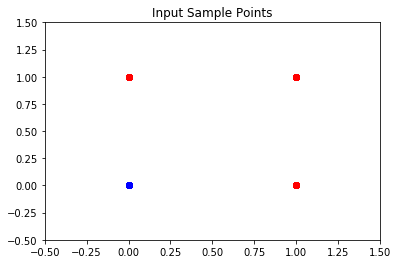

In [1]:
%matplotlib inline
import nengo
from nengo.dists import Uniform
from nengo.utils.ensemble import response_curves, tuning_curves
import numpy as np
import matplotlib.pyplot as plt

    
def generateData(n, function):
    """ 
    generates a 2D linearly separable bianry dataset 
    """
    inputs = []
    
    if function == "OR":
        for i in range(n):
            inputs.append([0,0,1,[0]])
            inputs.append([0,1,1,[1]])
            inputs.append([1,0,1,[1]])
            inputs.append([1,1,1,[1]])    
    else: # function = "AND" 
        for i in range(n):
            inputs.append([0,0,1,[0]])
            inputs.append([0,1,1,[0]])
            inputs.append([1,0,1,[0]])
            inputs.append([1,1,1,[1]]) 
    return inputs


samples = 140 
sets = samples / 4
data = generateData(sets, "OR")

plt.figure()
plt.title("Input Sample Points")
plt.xlim(-0.5,1.5)
plt.ylim(-0.5,1.5)
for x in data:
    if x[3][0] == 1:
        plt.plot(x[0], x[1], 'or')
    else:
        plt.plot(x[0], x[1], 'ob')

Three of the input sample points have an output of 1 (red) and one sample point has an output of 0 (blue). Note that this is a linearly separable set.

In [2]:
N = 30      #number of neurons
D_inp = 3
D_out = 1
factor = 3.0/4.0  
sim_time = samples
neuron_mode = nengo.Sigmoid(tau_ref=0.0025)  
model = nengo.Network('OR Network')

weights = np.random.rand(D_inp,D_out).transpose()    

with model:  
    
    def stim(t):
        for i in range(samples):
            if int(t) % samples <= i:
                return [data[i][0], data[i][1], data[i][2]]
        return 0
       
    def stim_ans(t):
        for i in range(samples):
            if int(t) % samples <= i:
                return data[i][3]
        return 0 
      
    #Define perceptron inputsa
    stim = nengo.Node(output=stim, size_out=D_inp)
    stim_ans = nengo.Node(output=stim_ans, size_out=D_out)

    #Create neural ensembles
    input = nengo.Ensemble(N*D_inp, dimensions=D_inp, neuron_type=neuron_mode, intercepts=Uniform(0.25, 1), max_rates=Uniform(350, 400), label="input") 
    answer = nengo.Ensemble(N*D_out, dimensions=D_out, neuron_type=neuron_mode, intercepts=Uniform(0.25, 1), max_rates=Uniform(350, 400), label="answer")  
    correct_answer = nengo.Ensemble(N*D_out, dimensions=D_out, intercepts=Uniform(0.25, 1), max_rates=Uniform(350, 400), neuron_type=neuron_mode, label="correct_answer")
      
    #Provide inputs to the perceptron
    nengo.Connection(stim, input) 
    nengo.Connection(stim_ans, correct_answer)
    
    #Compute error for learning which gets inhibited
    error = nengo.Ensemble(N*D_out, dimensions=D_out, intercepts=Uniform(0.25, 1), max_rates=Uniform(350, 400), neuron_type=neuron_mode, label="error")
    nengo.Connection(answer, error, transform=1)
    nengo.Connection(correct_answer, error, transform=-1)
    
    #Compute the actual error
    actual_error = nengo.Ensemble(N*D_out, dimensions=D_out, neuron_type=neuron_mode, label="actual_error")       
    nengo.Connection(answer ,actual_error, transform=1)
    nengo.Connection(correct_answer, actual_error, transform=-1)
    
    #Specify the learning rule and the weight solver
    conn = nengo.Connection(input, answer, transform=weights, solver=nengo.solvers.LstsqL2(weights=True)) 
    conn.learning_rule_type={'my_pes': nengo.PES(learning_rate = 1e-4)}
    
    #Provide error for learning
    error_conn = nengo.Connection(error, conn.learning_rule['my_pes'])
        
    #Inhibit learning after the training period
    def inhibit(t):
        return 2.0 if t > int(factor*samples) else 0.0
     
    inhib = nengo.Node(inhibit)
    nengo.Connection(inhib, error.neurons, transform=[[-10]] * error.n_neurons)

In [3]:
with model:
    input_p = nengo.Probe(input, synapse=0.1)
    answer_p = nengo.Probe(answer, synapse=0.1)
    correct_answer_p = nengo.Probe(correct_answer, synapse=0.1)
    error_p = nengo.Probe(error, synapse=0.1)
    actual_error = nengo.Probe(actual_error, synapse=0.1) 

In [4]:
sim = nengo.Simulator(model)
sim.run(sim_time)
t = sim.trange()

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

<IPython.core.display.Javascript object>

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

<IPython.core.display.Javascript object>

/home/jogama/code/cs525/std_neural_nets/lib/python2.7/site-packages/nengo/neurons.py:342: RuntimeWarning: overflow encountered in exp
  output[...] = (1. / self.tau_ref) / (1.0 + np.exp(-J))


Text(0.5,1,'Acutal Error')

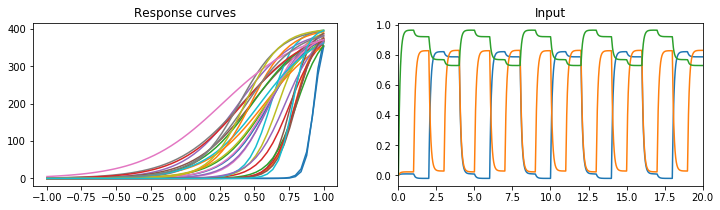

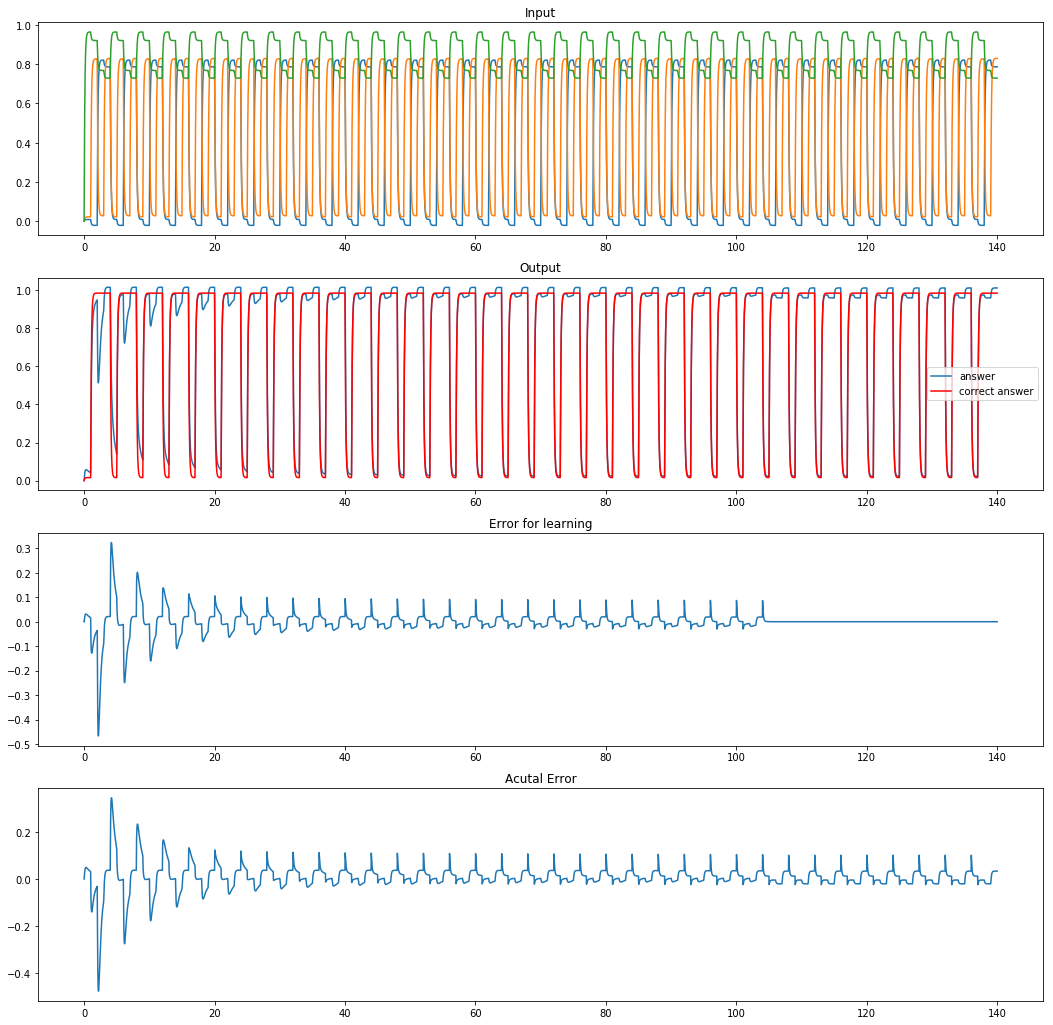

In [5]:
fig = plt.figure(figsize=(12, 3))
p0 = plt.subplot(1, 2, 1)
p0.plot(*response_curves(answer, sim))
p0.set_title("Response curves")

p1 = plt.subplot(1, 2, 2)
p1.plot(t, sim.data[input_p])
p1.set_title("Input")
p1.set_xlim(0,20)

fig = plt.figure(figsize=(18,18))

p0 = fig.add_subplot(4,1,1)
p0.plot(t, sim.data[input_p])
p0.set_title("Input")

p1 = fig.add_subplot(4,1,2)
p1.plot(t, sim.data[answer_p], label="answer")
p1.plot(t, sim.data[correct_answer_p], label="correct answer", color='r')
p1.set_title("Output")
p1.legend(loc='best');

p2 = fig.add_subplot(4,1,3)
p2.plot(t, sim.data[error_p])
p2.set_title("Error for learning")

p3 = fig.add_subplot(4,1,4)
p3.plot(t, sim.data[actual_error])
p3.set_title("Acutal Error")

The input plot shows that one input sample is provided to the perceptron every second. The 'output' plot and the 'Actual Error' plot above shows that the answer produced by the perceptron is very close to the correct answer even when the learning is turned off. The 'Error for learning' plot shows that the learning was turned off for the last quarter (i.e., the testing phase). 

Thus the network was successfully able to compute the OR function.

In [6]:
#Nengo GUI visualizer for visualizing the network
from nengo_gui.ipython import IPythonViz
IPythonViz(model)